<a href="https://colab.research.google.com/github/birddropping/IND5003-Group-Project/blob/main/IND5003_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
#from functools import reduce

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

In [2]:
data_demo = pd.read_csv('data/demographic.csv')
data_diet = pd.read_csv('data/diet.csv')
data_exam = pd.read_csv('data/examination.csv')
data_labs = pd.read_csv('data/labs.csv')
data_meds = pd.read_csv('data/medications.csv', encoding = "ISO-8859-1") # Had to use this encoding standard to read file
data_qns = pd.read_csv('data/questionnaire.csv')
data_dict = pd.read_excel('NHANES 2014 Dictionary.xlsx')

data_vari = pd.read_excel('Variables.xlsx', squeeze = True)

In [3]:
glu_data = pd.read_sas('data/GLU_H.XPT') # Fasting glucose was not part of the original dataset. Added from NHANES website
vitd_data = pd.read_sas('data/VID_H.XPT')
data_labs = pd.merge(data_labs, glu_data[['SEQN','LBDGLUSI']], how='outer', on=['SEQN'], validate = '1:1')
data_labs = pd.merge(data_labs, vitd_data[['SEQN','LBXVIDMS']], how='outer', on=['SEQN'], validate = '1:1')


In [4]:
#remove duplicates from data_meds as each line covers 1 medication
data_meds_m = data_meds.drop_duplicates(subset = ['SEQN', 'RXDCOUNT'], keep = 'first')


Combine the 6 datasets together as 1 with SEQN as the lead. From there, we can trim out the variables that is not needed for our application of diabetes and mental health.

In [5]:
# Create massive dataset
dataset = pd.merge(data_demo, data_diet, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_exam, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_labs, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_meds_m, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_qns, how = 'outer', on = ['SEQN'], validate = "1:1")

dataset

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC3,DMDEDUC2,DMDMARTL,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANGA,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGE,DMDHRBR4,DMDHREDU,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,PEASCST1,PEASCTM1,PEASCCT1,BPXCHR,BPAARM,BPACSZ,BPXPLS,BPXPULS,BPXPTY,BPXML1,BPXSY1,BPXDI1,BPAEN1,BPXSY2,BPXDI2,BPAEN2,BPXSY3,BPXDI3,BPAEN3,BPXSY4,BPXDI4,BPAEN4,BMDSTATS,BMXWT,BMIWT,BMXRECUM,BMIRECUM,BMXHEAD,BMIHEAD,BMXHT,BMIHT,BMXBMI,BMDBMIC,BMXLEG,BMILEG,BMXARML,...,PAQ755,PAQ759A,PAQ759B,PAQ759C,PAQ759D,PAQ759E,PAQ759F,PAQ759G,PAQ759H,PAQ759I,PAQ759J,PAQ759K,PAQ759L,PAQ759M,PAQ759N,PAQ759O,PAQ759P,PAQ759Q,PAQ759R,PAQ759S,PAQ759T,PAQ759U,PAQ759V,PAQ762,PAQ764,PAQ766,PAQ679,PAQ750,PAQ770,PAQ772A,PAQ772B,PAQ772C,PAAQUEX,PUQ100,PUQ110,RHQ010,RHQ020,RHQ031,RHD043,RHQ060,RHQ070,RHQ074,RHQ076,RHQ078,RHQ131,RHD143,RHQ160,RHQ162,RHQ163,RHQ166,RHQ169,RHQ172,RHD173,RHQ171,RHD180,RHD190,RHQ197,RHQ200,RHD280,RHQ291,RHQ305,RHQ332,RHQ420,RHQ540,RHQ542A,RHQ542B,RHQ542C,RHQ542D,RHQ554,RHQ560Q,RHQ560U,RHQ570,RHQ576Q,RHQ576U,RHQ580,RHQ586Q,RHQ586U,RHQ596,RHQ602Q,RHQ602U,RXQ510,RXQ515,RXQ520,RXQ525G,RXQ525Q,RXQ525U,RXD530,SLD010H,SLQ050,SLQ060,SMQ020,SMD030,SMQ040,SMQ050Q,SMQ050U,SMD055,SMD057,SMQ078,SMD641,SMD650,SMD093,SMDUPCA,SMD100BR,SMD100FL,SMD100MN,SMD100LN,SMD100TR,SMD100NI,SMD100CO,SMQ621,SMD630,SMQ661,SMQ665A,SMQ665B,SMQ665C,SMQ665D,SMQ670,SMQ848,SMQ852Q,SMQ852U,SMAQUEX2,SMD460,SMD470,SMD480,SMQ856,SMQ858,SMQ860,SMQ862,SMQ866,SMQ868,SMQ870,SMQ872,SMQ874,SMQ876,SMQ878,SMQ880,SMAQUEX.x,SMQ681,SMQ690A,SMQ710,SMQ720,SMQ725,SMQ690B,SMQ740,SMQ690C,SMQ770,SMQ690G,SMQ845,SMQ690H,SMQ849,SMQ851,SMQ690D,SMQ800,SMQ690E,SMQ817,SMQ690I,SMQ857,SMQ690J,SMQ861,SMQ863,SMQ690F,SMQ830,SMQ840,SMDANY,SMAQUEX.y,SXD021,SXQ800,SXQ803,SXQ806,SXQ809,SXQ700,SXQ703,SXQ706,SXQ709,SXD031,SXD171,SXD510,SXQ824,SXQ827,SXD633,SXQ636,SXQ639,SXD642,SXQ410,SXQ550,SXQ836,SXQ841,SXQ853,SXD621,SXQ624,SXQ627,SXD630,SXQ645,SXQ648,SXQ610,SXQ251,SXQ590,SXQ600,SXD101,SXD450,SXQ724,SXQ727,SXQ130,SXQ490,SXQ741,SXQ753,SXQ260,SXQ265,SXQ267,SXQ270,SXQ272,SXQ280,SXQ292,SXQ294,WHD010,WHD020,WHQ030,WHQ040,WHD050,WHQ060,WHQ070,WHD080A,WHD080B,WHD080C,WHD080D,WHD080E,WHD080F,WHD080G,WHD080H,WHD080I,WHD080J,WHD080K,WHD080M,WHD080N,WHD080O,WHD080P,WHD080Q,WHD080R,WHD080S,WHD080T,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,1.0,1.0,1,1

In [6]:
# Create list of variables of interest
col_list = data_vari.tolist()

# Creating dataframe with variables of interest
final_data = dataset[col_list]

# Subsetting based on glycohaemoglobin levels
final_data = final_data.dropna(subset=['LBXGH']) 

#inputs=dataset[['SEQN','Diet spending','Depression score']]
#final_data=final_data.merge(inputs)

final_data

,SEQN,RXDCOUNT,RXDDAYS,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,BPXSY1,BPXDI1,BPXSY2,BPXDI2,BPXSY3,BPXDI3,DR1TALCO,DR1.320Z,LBDGLTSI,LBDGLUSI,LBDHDDSI,LBDTCSI,LBXVIDMS,LBXGH,DIQ160,DIQ170,DIQ172,DIQ175A,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100,PAQ605,PAQ610,PAD615,PAQ620,PAQ625,PAD630,PAQ635,PAQ640,PAD645,PAQ650,PAQ655,PAD660,PAQ665,PAQ670,PAD675,PAD680,PAQ710,PAQ715,WHQ030,WHQ070,DBQ700,HSD010,WHD110,WHD120,BMXWT
0,73557,2.0,NaN,1,69,4,26.7,122.0,72.0,114.0,76.0,102.0,74.0,0.0,960.0,NaN,NaN,1.68,4.32,28.9,13.9,NaN,NaN,NaN,NaN,8.0,8.0,0.0,4.0,2.0,1.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,600.0,2.0,8.0,3.0,NaN,2.0,2.0,270.0,200.0,78.3
1,73558,4.0,243.0,1,54,3,28.6,156.0,62.0,160.0,80.0,156.0,42.0,119.0,360.0,NaN,NaN,1.29,4.40,61.9,9.1,NaN,NaN,NaN,NaN,0.0,NaN,0.0,2.0,2.0,1.0,7.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,1.0,1.0,10.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,540.0,4.0,8.0,3.0,2.0,3.0,4.0,240.0,250.0,89.5
2,73559,5.0,365.0,1,72,3,28.9,140.0,90.0,140.0,76.0,146.0,80.0,0.0,1254.0,NaN,10.713,1.55,3.26,126.0,8.9,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,2.0,2.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,1.0,7.0,30.0,2.0,NaN,NaN,2.0,NaN,NaN,1.0,1.0,180.0,300.0,4.0,0.0,3.0,2.0,3.0,3.0,180.0,190.0,88.9
4,73561,4.0,152.0,2,73,3,19.7,136.0,86.0,134.0,88.0,142.0,86.0,0.0,240.0,NaN,5.940,2.20,5.20,108.0,4.9,2.0,2.0,2.0,NaN,0.0,NaN,4.0,1.0,2.0,2.0,15.0,15.0,2.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,1.0,2.0,30.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,480.0,1.0,1.0,2.0,2.0,2.0,5.0,150.0,135.0,52.0
5,73562,7.0,365.0,1,56,1,41.7,160.0,84.0,158.0,82.0,154.0,80.0,0.0,1014.0,NaN,NaN,0.98,5.84,44.3,5.5,2.0,2.0,1.0,NaN,14.0,14.0,0.0,0.0,2.0,2.0,9.0,9.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,1.0,0.0,3.0,1.0,5.0,240.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,360.0,5.0,8.0,1.0,1.0,5.0,5.0,225.0,195.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10164,83721,1.0,91.0,1,52,3,25.6,108.0,70.0,112.0,72.0,108.0,76.0,0.0,0.0,NaN,NaN,1.42,3.57,109.0,5.4,2.0,2.0,2.0,NaN,15.0,0.0,0.0,0.0,2.0,2.0,15.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,4.0,120.0,1.0,3.0,120.0,240.0,2.0,8.0,3.0,2.0,1.0,2.0,172.0,163.0,79.5
10166,83723,NaN,NaN,1,61,1,33.1,NaN,NaN,138.0,60.0,142.0,68.0,0.0,3000.0,NaN,8.826,1.27,4.81,59.4,7.4,NaN,NaN,NaN,NaN,1.0,0.0,0.0,2.0,2.0,1.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,2.0,30.0,360.0,3.0,8.0,1.0,NaN,3.0,4.0,240.0,200.0,99.5
10167,83724,5.0,10950.0,1,80,3,24.9,164.0,70.0,168.0,66.0,168.0,66.0,0.0,690.0,NaN,NaN,1.32,4.06,89.9,5.5,2.0,2.0,2.0,NaN,1.0,1.0,0.0,30.0,2.0,2.0,8.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,7.0,60.0,360.0,2.0,8.0,3.0,2.0,2.0,2.0,173.0,140.0,77.1
10170,83727,NaN,NaN,1,26,2,24.5,110.0,68.0,116.0,74.0,112.0,76.0,14.0,867.0,5.995,5.995,1.42,4.91,81.5,5.0,2.0,2.0,2.0,NaN,1.0,1.0,2.0,2.0,2.0,2.0,77.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,600.0,2.0,1.0,3.0,2.0,4.0,3.0,NaN,NaN,71.8


In [7]:
X = final_data.drop('LBXGH', axis=1)
y = np.where(final_data['LBXGH'] >=6.5, 1, 0)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

As shown in previous cell, all datasets have been combined and only features related to diabetes and mental health have been filtered out to create the dataset from which analysis will be done.

In [9]:
SES = ['INDHHIN2', 'INDFMIN2', 'FSD151', 'FSQ165']
SES_data_train = X_train[SES]
SES_data_test = X_test[SES]

Coded results for household/family income

|Value|Salary Range|
|-----|------------|
|1|0 to 4999|
|2|5000 to 9999|
|3|10000 to 14999|
|4|15000 to 19999|
|5|20000 to 24999|
|6|25000 to 34999|
|7|35000 to 44999|
|8|45000 to 54999|
|9|55000 to 64999|
|10|65000 to 74999|
|12|20000 and over|
|13|under 20000|
|14|75000 to 99999|
|15|100000 and over|

We will have to replace NaN values, 77 and 99 which are refuse to answer and do not know respectively.

In [10]:
#Replace 77.0 and 99.0 with NaN value first, before replacing all NaN values with the mean of the remainder.
SES_data_train.loc[:,'INDHHIN2'] = SES_data_train.loc[:,'INDHHIN2'].replace(77.0, np.NaN)
SES_data_train.loc[:,'INDHHIN2'] = SES_data_train.loc[:,'INDHHIN2'].replace(99.0, np.NaN)
SES_data_test.loc[:,'INDHHIN2'] = SES_data_test.loc[:,'INDHHIN2'].replace(77.0, np.NaN)
SES_data_test.loc[:,'INDHHIN2'] = SES_data_test.loc[:,'INDHHIN2'].replace(99.0, np.NaN)
#Round function used to keep integer values only within the Dataframe
SES_data_train.loc[:,'INDHHIN2'] = SES_data_train.loc[:,'INDHHIN2'].fillna(round(SES_data_train.loc[:,'INDHHIN2'].mean()))
SES_data_test.loc[:,'INDHHIN2'] = SES_data_test.loc[:,'INDHHIN2'].fillna(round(SES_data_train.loc[:,'INDHHIN2'].mean()))


SES_data_train.loc[:,'INDFMIN2'] = SES_data_train.loc[:,'INDFMIN2'].replace(77.0, np.NaN)
SES_data_train.loc[:,'INDFMIN2'] = SES_data_train.loc[:,'INDFMIN2'].replace(99.0, np.NaN)
SES_data_test.loc[:,'INDFMIN2'] = SES_data_test.loc[:,'INDFMIN2'].replace(77.0, np.NaN)
SES_data_test.loc[:,'INDFMIN2'] = SES_data_test.loc[:,'INDFMIN2'].replace(99.0, np.NaN)
#Round function used to keep integer values only within the Dataframe
SES_data_train.loc[:,'INDFMIN2'] = SES_data_train.loc[:,'INDFMIN2'].fillna(round(SES_data_train.loc[:,'INDFMIN2'].mean()))
SES_data_test.loc[:,'INDFMIN2'] = SES_data_test.loc[:,'INDFMIN2'].fillna(round(SES_data_train.loc[:,'INDFMIN2'].mean()))

In [11]:
#Too many catergories that are not in order to make sense when plotting a histogram
#Convert data values to only have 4 catergories

#Cat 1 is under 20000
replace_values_cat1 = {2:1, 3:1, 4:1, 13:1}
#Cat 2 is 20000 to 74999
replace_values_cat2 = {5:2, 6:2, 7:2, 8:2, 9:2, 10:2, 12:2}
#Cat 3 is 75000 to 99999
replace_values_cat3 = {14:3}
#Cat 4 is 100000 and above
replace_values_cat4 = {15:4}

#Replace the values in 'INDHHIN2' to create 4 catergories
SES_data_train['INDHHIN2'].replace(replace_values_cat1, inplace=True)
SES_data_train['INDHHIN2'].replace(replace_values_cat2, inplace=True)
SES_data_train['INDHHIN2'].replace(replace_values_cat3, inplace=True)
SES_data_train['INDHHIN2'].replace(replace_values_cat4, inplace=True)
SES_data_test['INDHHIN2'].replace(replace_values_cat1, inplace=True)
SES_data_test['INDHHIN2'].replace(replace_values_cat2, inplace=True)
SES_data_test['INDHHIN2'].replace(replace_values_cat3, inplace=True)
SES_data_test['INDHHIN2'].replace(replace_values_cat4, inplace=True)


#Replace the values in 'INDFMIN2' to create 4 catergories
SES_data_train['INDFMIN2'].replace(replace_values_cat1, inplace=True)
SES_data_train['INDFMIN2'].replace(replace_values_cat2, inplace=True)
SES_data_train['INDFMIN2'].replace(replace_values_cat3, inplace=True)
SES_data_train['INDFMIN2'].replace(replace_values_cat4, inplace=True)
SES_data_test['INDFMIN2'].replace(replace_values_cat1, inplace=True)
SES_data_test['INDFMIN2'].replace(replace_values_cat2, inplace=True)
SES_data_test['INDFMIN2'].replace(replace_values_cat3, inplace=True)
SES_data_test['INDFMIN2'].replace(replace_values_cat4, inplace=True)

X_train.loc[:,'INDFMIN2'] = SES_data_train.loc[:,'INDFMIN2']
X_train.loc[:,'INDHHIN2'] = SES_data_train.loc[:,'INDHHIN2']
X_test.loc[:,'INDFMIN2'] = SES_data_test.loc[:,'INDFMIN2']
X_test.loc[:,'INDHHIN2'] = SES_data_test.loc[:,'INDHHIN2']

In [12]:
check=[11]
#check that the value 11 is not in the column as it is not represented in the value coding table above for feature
# INDHHIN2 and INDFMIN2 which are household income and family income respectively
SES_data_train['INDHHIN2'].isin(check).sum()

0

In [13]:
#Should be removed before main integration for project submission

SES_data_train['INDFMIN2'].isin(check).sum()

0

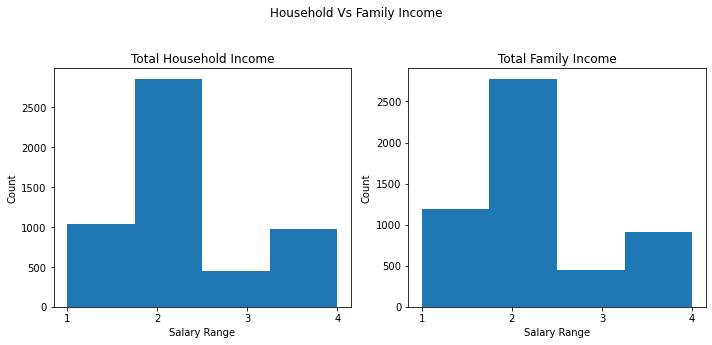

In [14]:
#Plot the income indicators into histograms according to the new catergories that we arranged them in

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist(SES_data_train['INDHHIN2'], bins=4)
ax1.set_ylabel("Count")
ax1.set_xlabel("Salary Range")
ax1.set_title("Total Household Income")
ax1.set_xticks([1,2,3,4]) 
ax1.set_xticklabels([1,2,3,4])

ax2.hist(SES_data_train['INDFMIN2'], bins=4)
ax2.set_ylabel("Count")
ax2.set_xlabel("Salary Range")
ax2.set_title("Total Family Income")
ax2.set_xticks([1,2,3,4]) 
ax2.set_xticklabels([1,2,3,4])

fig.suptitle("Household Vs Family Income")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [15]:
SES_data_train['FSD151'].replace(7.0, np.NaN, inplace=True)
SES_data_train['FSD151'].replace(9.0, np.NaN, inplace=True)
SES_data_test['FSD151'].replace(7.0, np.NaN, inplace=True)
SES_data_test['FSD151'].replace(9.0, np.NaN, inplace=True)
#Round function used to keep integer values only within the Dataframe
SES_data_train['FSD151'].fillna(round(SES_data_train['FSD151'].mean()), inplace=True)
SES_data_test['FSD151'].fillna(round(SES_data_train['FSD151'].mean()), inplace=True)

SES_data_train['FSQ165'].replace(7.0, np.NaN, inplace=True)
SES_data_train['FSQ165'].replace(9.0, np.NaN, inplace=True)
SES_data_test['FSQ165'].replace(7.0, np.NaN, inplace=True)
SES_data_test['FSQ165'].replace(9.0, np.NaN, inplace=True)
#Round function used to keep integer values only within the Dataframe
SES_data_train['FSQ165'].fillna(round(SES_data_train['FSQ165'].mean()), inplace=True)
SES_data_test['FSQ165'].fillna(round(SES_data_train['FSQ165'].mean()), inplace=True)


X_train['FSD151'] = SES_data_train['FSD151']
X_train['FSQ165'] = SES_data_train['FSQ165']
X_test['FSD151'] = SES_data_test['FSD151']
X_test['FSQ165'] = SES_data_test['FSQ165']

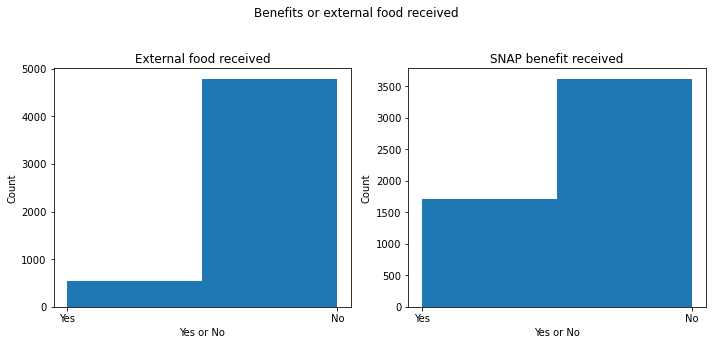

In [16]:
# Features showing benefit

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist(SES_data_train['FSD151'], bins=2)
ax1.set_ylabel("Count")
ax1.set_xlabel("Yes or No")
ax1.set_title("External food received")
ax1.set_xticks([1,2]) 
ax1.set_xticklabels(['Yes','No'])

ax2.hist(SES_data_train['FSQ165'], bins=2)
ax2.set_ylabel("Count")
ax2.set_xlabel("Yes or No")
ax2.set_title("SNAP benefit received")
ax2.set_xticks([1,2]) 
ax2.set_xticklabels(['Yes','No'])

fig.suptitle("Benefits or external food received")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [17]:
# subsetting dataset based on available HbA1c data
mh = ['SEQN','DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100']
mental_health_train = X_train[mh]
mental_health_test = X_test[mh]

mental_health_train.loc[:,'DPQ_score'] = mental_health_train.drop('SEQN', axis=1).sum(axis=1) # summing up scores
mental_health_test.loc[:,'DPQ_score'] = mental_health_test.drop('SEQN', axis=1).sum(axis=1) # summing up scores

# mental health summary statistic - 4 categories - 0 for normal, 1 for mild, 2 for moderate, 3 for severe
X_train.loc[:,'mental_health_stat'] = pd.cut(mental_health_train['DPQ_score'], [0,4,9,14,27], labels=[0,1,2,3], include_lowest = True)
X_test.loc[:,'mental_health_stat'] = pd.cut(mental_health_test['DPQ_score'], [0,4,9,14,27], labels=[0,1,2,3], include_lowest = True)

X_train = X_train.drop(['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100'], axis=1)
X_test = X_test.drop(['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100'], axis=1)

In [18]:
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value
X_train.loc[:,'WHQ030'] = X_train['WHQ030'].fillna(3).replace(9,3) 
X_test.loc[:,'WHQ030'] = X_test['WHQ030'].fillna(3).replace(9,3) 
# selecting 'no' for individuals who did not respond to this qn, replacing 'unsure' responses with nil response
X_train.loc[:,'WHQ070'] = X_train['WHQ070'].fillna(2).replace(9,2) 
X_test.loc[:,'WHQ070'] = X_test['WHQ070'].fillna(2).replace(9,2) 
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value
X_train.loc[:,'DBQ700'] = X_train['DBQ700'].fillna(3).replace(9,3)
X_test.loc[:,'DBQ700'] = X_test['DBQ700'].fillna(3).replace(9,3)
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value\
X_train.loc[:,'HSD010'] = X_train['HSD010'].fillna(3).replace(9,3)
X_test.loc[:,'HSD010'] = X_test['HSD010'].fillna(3).replace(9,3)

# Subsetting and creating scores for individual self-perception questions
sp = ['SEQN','WHQ030','WHQ070','DBQ700', 'HSD010']
self_perception_train = X_train[sp]
self_perception_test = X_test[sp]
self_perception_train.loc[:,'WHQ030_score'] = self_perception_train['WHQ030'].replace([1,2],0).replace(3,2)
self_perception_train.loc[:,'WHQ070_score'] = self_perception_train['WHQ070'].replace(1,0)
self_perception_train.loc[:,'DBQ700_score'] = self_perception_train['DBQ700']-1
self_perception_train.loc[:,'HSD010_score'] = self_perception_train['HSD010']-1
self_perception_test.loc[:,'WHQ030_score'] = self_perception_test['WHQ030'].replace([1,2],0).replace(3,2)
self_perception_test.loc[:,'WHQ070_score'] = self_perception_test['WHQ070'].replace(1,0)
self_perception_test.loc[:,'DBQ700_score'] = self_perception_test['DBQ700']-1
self_perception_test.loc[:,'HSD010_score'] = self_perception_test['HSD010']-1

# Creating summary score for self perception
self_perception_train.loc[:,'self_perception_stat'] = self_perception_train[['WHQ030_score','WHQ070_score','DBQ700_score','HSD010_score']].sum(axis=1)
X_train.loc[:,'self_perception_stat'] = pd.cut(self_perception_train.loc[:,'self_perception_stat'], [0,3,6,9,12], labels=[0,1,2,3], include_lowest = True)
self_perception_test.loc[:,'self_perception_stat'] = self_perception_test[['WHQ030_score','WHQ070_score','DBQ700_score','HSD010_score']].sum(axis=1)
X_test.loc[:,'self_perception_stat'] = pd.cut(self_perception_test.loc[:,'self_perception_stat'], [0,3,6,9,12], labels=[0,1,2,3], include_lowest = True)

X_train = X_train.drop(['WHQ030','WHQ070','DBQ700','HSD010'], axis=1)
X_test = X_test.drop(['WHQ030','WHQ070','DBQ700','HSD010'], axis=1)

In [19]:
# Cleaning number of medications
X_train['RXDCOUNT'] = X_train['RXDCOUNT'].replace(np.NaN, 0)
X_test['RXDCOUNT'] = X_test['RXDCOUNT'].replace(np.NaN, 0)

# Defining average blood pressure
X_train.loc[:,'AVGSYBP'] = round(X_train[['BPXSY1','BPXSY2','BPXSY3']].mean(axis=1))
X_train.loc[:,'AVGDIBP'] = round(X_train[['BPXDI1','BPXDI2','BPXDI3']].mean(axis=1))
X_test.loc[:,'AVGSYBP'] = round(X_test[['BPXSY1','BPXSY2','BPXSY3']].mean(axis=1))
X_test.loc[:,'AVGDIBP'] = round(X_test[['BPXDI1','BPXDI2','BPXDI3']].mean(axis=1))

# Dropping base features relating to 1,2,3 measurements of Systolic and Diastolic BP
X_train = X_train.drop(['BPXSY1','BPXSY2','BPXSY3','BPXDI1','BPXDI2','BPXDI3'], axis=1)
X_test = X_test.drop(['BPXSY1','BPXSY2','BPXSY3','BPXDI1','BPXDI2','BPXDI3'], axis=1)

# Cleaning data for DBD895. >21 responses normalized to 21. Unsure participants normalized to mean number of meals based on train set
X_train['DBD895'] = X_train['DBD895'].replace({5555:21, 9999:np.NaN, 7777:np.NaN}).replace(np.NaN, round(np.mean(X_train['DBD895'])))
X_train['DBD900'] = X_train['DBD900'].replace({5555:21, 9999:np.NaN}).replace(np.NaN, round(np.mean(X_train['DBD900'])))
X_test['DBD895'] = X_test['DBD895'].replace({5555:21, 9999:np.NaN, 7777:np.NaN}).replace(np.NaN, round(np.mean(X_train['DBD895'])))
X_test['DBD900'] = X_test['DBD900'].replace({5555:21, 9999:np.NaN}).replace(np.NaN, round(np.mean(X_train['DBD900'])))

# Calculating proportion of fast food compared to all other meals consumed outside
avg_meals_train = X_train['DBD900'] / X_train['DBD895']
avg_meals_train = avg_meals_train.replace(np.inf, 0)
avg_meals_train = avg_meals_train.where(avg_meals_train < 1 ,1)
X_train['PROFFMEAL'] = avg_meals_train
avg_meals_test = X_test['DBD900'] / X_test['DBD895']
avg_meals_test = avg_meals_test.replace(np.inf, 0)
avg_meals_test = avg_meals_test.where(avg_meals_test < 1 ,1)
X_test['PROFFMEAL'] = avg_meals_test

X_train['DBD905'] = X_train['DBD905'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(X_train['DBD905'])))   
X_train['DBD910'] = X_train['DBD910'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(X_train['DBD910'])))   
X_test['DBD905'] = X_test['DBD905'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(X_train['DBD905'])))   
X_test['DBD910'] = X_test['DBD910'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(X_train['DBD910'])))   

X_train.drop(['RXDDAYS','LBDGLTSI','LBDGLUSI','DIQ160','DIQ170','DIQ172','DIQ175A','WHD110','WHD120'],axis=1, inplace=True)
X_test.drop(['RXDDAYS','LBDGLTSI','LBDGLUSI','DIQ160','DIQ170','DIQ172','DIQ175A','WHD110','WHD120'],axis=1, inplace=True)

In [20]:
#Create working database for activity
activity = ["PAQ605", "PAQ620", "PAQ635", "PAQ650", "PAQ665", "PAD680", "PAQ710", "PAQ715"]
activity_wk_train = X_train.loc[:,activity]
activity_wk_test = X_test.loc[:,activity]

#drop "PAQ706" due to poor data
#code out target variable "DM"
#code activity levels
activity1 = ["PAQ605", "PAQ620", "PAQ635", "PAQ650", "PAQ665", "PAD680", "PAQ710", "PAQ715"]
activity_wk_train = X_train.loc[:,activity1]
#activity_wk_train["DM"] = activity_wk_train["LBXGH"]>6.5
activity_wk_train["activity_lvl_high"] = np.where((activity_wk_train.PAQ650 == 1) | (activity_wk_train.PAQ605 == 1), 1, np.NaN)
activity_wk_train["activity_lvl_med"] = np.where((activity_wk_train["PAQ620"] == 1) | (activity_wk_train["PAQ665"] == 1), 2, np.NaN)
activity_wk_train["activity_lvl_low"] =  (activity_wk_train["PAQ605" and "PAQ650" and "PAQ620" and "PAQ665"] !=1)
activity_wk_test = X_test.loc[:,activity1]
#activity_wk_test["DM"] = activity_wk_test["LBXGH"]>6.5
activity_wk_test["activity_lvl_high"] = np.where((activity_wk_test.PAQ650 == 1) | (activity_wk_test.PAQ605 == 1), 1, np.NaN)
activity_wk_test["activity_lvl_med"] = np.where((activity_wk_test["PAQ620"] == 1) | (activity_wk_test["PAQ665"] == 1), 2, np.NaN)
activity_wk_test["activity_lvl_low"] =  (activity_wk_test["PAQ605" and "PAQ650" and "PAQ620" and "PAQ665"] !=1)

activity_wk_train["activity_lvl_low"].replace(True, 3, inplace=True)
activity_wk_train["activity_lvl_low"].replace(False, np.NaN, inplace=True)
#activity_wk[activity_wk["activity_lvl_high"]==0].replace(0,activity_wk["activity_lvl_med"], inplace=True )
#activity_wk["activity_lvl_high"].replace(0,activity_wk["activity_lvl_med"], inplace =True)
activity_wk_train["activity_lvl"] = activity_wk_train[["activity_lvl_high", "activity_lvl_med", "activity_lvl_low"]].min(axis=1)
activity_wk_test["activity_lvl_low"].replace(True, 3, inplace=True)
activity_wk_test["activity_lvl_low"].replace(False, np.NaN, inplace=True)
activity_wk_test["activity_lvl"] = activity_wk_test[["activity_lvl_high", "activity_lvl_med", "activity_lvl_low"]].min(axis=1)


X_train['activity_lvl'] = activity_wk_train['activity_lvl']
X_test['activity_lvl'] = activity_wk_test['activity_lvl']

X_train.drop(["PAQ605",'PAQ610','PAD615', "PAQ620",'PAQ625','PAD630', "PAQ635", 'PAQ640','PAD645', "PAQ650", 'PAQ655','PAD660', "PAQ665", 'PAQ670','PAD675', "PAD680", "PAQ710", "PAQ715"], axis=1, inplace=True)
X_test.drop(["PAQ605",'PAQ610','PAD615', "PAQ620",'PAQ625','PAD630', "PAQ635", 'PAQ640','PAD645', "PAQ650", 'PAQ655','PAD660', "PAQ665", 'PAQ670','PAD675', "PAD680", "PAQ710", "PAQ715"], axis=1, inplace=True)

In [21]:
# Reindexing train and test sets for dropping of NA values. 

X_train = X_train.reset_index().drop('index',axis=1)
tmp_train = pd.concat((X_train, pd.DataFrame(y_train)), axis=1)

X_test = X_test.reset_index().drop('index',axis=1)
tmp_test = pd.concat((X_test, pd.DataFrame(y_test)), axis=1)

tmp_train.dropna(axis=0,how='any', inplace = True)
tmp_test.dropna(axis=0,how='any', inplace = True)

In [22]:
X_train = tmp_train.drop(0,axis=1)
y_train = tmp_train.iloc[:,-1]
X_test = tmp_test.drop(0,axis=1)
y_test = tmp_test.iloc[:,-1]

In [23]:
X_train

,SEQN,RXDCOUNT,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,DR1TALCO,DR1.320Z,LBDHDDSI,LBDTCSI,LBXVIDMS,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,BMXWT,mental_health_stat,self_perception_stat,AVGSYBP,AVGDIBP,PROFFMEAL,activity_lvl
0,77811,0.0,1,55,5,24.6,29.1,0.0,0.91,4.65,38.4,0.0,5.0,0.0,0.0,2.0,2.0,2.0,2.0,74.5,0,2,152.0,85.0,0.000000,3.0
1,75924,1.0,1,30,5,14.1,0.0,240.0,1.29,4.06,39.5,0.0,5.0,0.0,0.0,1.0,1.0,2.0,2.0,32.8,1,2,109.0,65.0,0.000000,3.0
2,82642,3.0,2,66,2,27.0,4.7,150.0,1.11,6.39,74.4,0.0,5.0,0.0,0.0,2.0,1.0,1.0,1.0,62.4,3,2,170.0,96.0,0.000000,3.0
3,80456,2.0,2,47,5,21.4,0.0,1095.0,1.40,4.76,94.4,3.0,2.0,1.0,2.0,2.0,2.0,3.0,3.0,49.2,0,1,105.0,65.0,0.666667,1.0
4,76755,0.0,2,42,3,37.2,0.0,5760.0,1.24,3.18,58.3,10.0,5.0,15.0,15.0,2.0,2.0,3.0,3.0,107.0,0,1,109.0,68.0,0.500000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5308,77746,0.0,1,36,3,23.6,11.2,180.0,1.19,3.54,73.7,5.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,79.4,0,2,119.0,85.0,0.600000,1.0
5309,80040,2.0,2,70,4,22.0,0.0,525.0,1.37,4.97,35.6,5.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,65.1,0,2,155.0,80.0,0.000000,3.0
5310,76423,7.0,2,74,3,22.1,19.2,1575.0,0.91,5.51,113.0,2.0,0.0,12.0,0.0,2.0,2.0,2.0,2.0,57.6,0,2,127.0,57.0,0.000000,3.0
5312,77206,0.0,2,20,4,23.8,0.0,75.0,2.07,4.22,43.9,0.0,5.0,2.0,3.0,2.0,2.0,3.0,3.0,66.8,0,1,107.0,67.0,0.000000,1.0


In [24]:
X_test

,SEQN,RXDCOUNT,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,DR1TALCO,DR1.320Z,LBDHDDSI,LBDTCSI,LBXVIDMS,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,BMXWT,mental_health_stat,self_perception_stat,AVGSYBP,AVGDIBP,PROFFMEAL,activity_lvl
0,78898,0.0,2,37,2,21.5,0.0,1200.00,1.68,6.00,56.4,3.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,59.0,0,1,93.0,63.0,0.333333,2.0
1,77049,1.0,2,66,5,30.2,0.0,1267.50,1.24,3.62,43.4,1.0,1.0,3.0,0.0,2.0,2.0,2.0,2.0,60.0,0,2,143.0,68.0,1.000000,2.0
3,81895,3.0,2,64,4,23.2,0.0,480.00,1.91,5.12,77.8,1.0,0.0,1.0,4.0,2.0,2.0,2.0,2.0,58.7,1,1,124.0,81.0,0.000000,1.0
4,80893,10.0,2,56,3,49.4,0.0,1701.15,0.96,3.96,67.7,3.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,124.6,2,1,119.0,37.0,1.000000,3.0
5,77057,1.0,2,80,3,22.1,0.0,435.00,1.91,5.09,48.0,3.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,59.7,0,2,135.0,59.0,0.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1324,83183,2.0,1,76,1,32.3,56.2,0.00,0.85,2.90,123.0,5.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,100.2,0,1,128.0,57.0,0.000000,2.0
1325,78771,3.0,1,80,3,32.0,0.0,240.00,1.01,4.06,81.6,3.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,89.9,0,1,111.0,48.0,0.000000,3.0
1326,77878,4.0,2,47,1,40.9,42.1,180.00,1.27,5.82,67.7,1.0,1.0,0.0,3.0,2.0,1.0,1.0,1.0,100.8,3,1,105.0,73.0,1.000000,3.0
1327,82769,5.0,2,55,5,27.3,0.0,0.00,1.71,5.40,60.7,1.0,0.0,0.0,0.0,2.0,1.0,4.0,4.0,57.4,0,2,106.0,71.0,0.000000,3.0


  
  
# Logistic Regression
  
  

In [25]:
#import relevant libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn import set_config
from sklearn.feature_selection import SelectFromModel, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
set_config(display='diagram')

In [26]:
#feature selection
#scale features
scaler = StandardScaler()
X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.fit_transform(X_test)

In [27]:
X_train_n

array([[-0.28220179, -0.65649273, -1.03207968, ...,  1.30015728,
        -0.98584454,  1.36233695],
       [-0.92684638, -0.29962491, -1.03207968, ..., -0.15846944,
        -0.98584454,  1.36233695],
       [ 1.36818402,  0.41411074,  0.96891744, ...,  2.10240197,
        -0.98584454,  1.36233695],
       ...,
       [-0.75637598,  1.84158204,  0.96891744, ..., -0.74192013,
        -0.98584454,  1.36233695],
       [-0.48888434, -0.65649273,  0.96891744, ..., -0.01260677,
        -0.98584454, -1.0619669 ],
       [ 1.27492065, -0.65649273,  0.96891744, ..., -0.66898879,
         1.3474481 ,  1.36233695]])

In [28]:
#feature selection
#identify features
selector = SelectFromModel(estimator=LogisticRegression()).fit(X_train_n, y_train)

In [29]:
selector.estimator_.coef_

array([[ 0.00215398,  0.54134518, -0.12093533,  0.75871908, -0.04796895,
         0.33700604, -0.04112464,  0.06137807, -0.40069509,  0.04704904,
        -0.28635023, -0.01575189, -0.00130034,  0.01612802, -0.01564107,
         0.00156145,  0.04517408, -0.56668677,  0.61937142,  0.1311916 ,
        -0.03549523,  0.17119827,  0.24337653, -0.03924101, -0.08428315,
         0.07157419]])

In [30]:
selector.threshold_

0.1808731013451194

In [31]:
selector.get_support()

array([False,  True, False,  True, False,  True, False, False,  True,
       False,  True, False, False, False, False, False, False,  True,
        True, False, False, False,  True, False, False, False])

In [32]:
selector.transform(X_train_n)

array([[-0.65649273,  0.61814672, -0.5123312 , ..., -0.28967565,
        -0.23465744,  1.82647722],
       [-0.29962491, -0.60907106, -1.96462581, ..., -0.28967565,
        -0.23465744, -0.66149215],
       [ 0.41411074,  1.15812255, -0.18037815, ..., -1.31398809,
        -1.25311012,  2.86795277],
       ...,
       [ 1.84158204,  1.55083224, -0.85811563, ..., -0.28967565,
        -0.23465744,  0.3799834 ],
       [-0.65649273, -1.09995817, -0.62298222, ...,  0.7346368 ,
         0.78379523, -0.77721166],
       [-0.65649273, -0.26545008,  0.70483   , ..., -0.28967565,
        -0.23465744, -1.00865067]])

In [33]:
X_train.columns[selector.get_support()]

Index(['RXDCOUNT', 'RIDAGEYR', 'BMXBMI', 'LBDHDDSI', 'LBXVIDMS', 'INDHHIN2', 'INDFMIN2', 'AVGSYBP'], dtype='object')

In [34]:
#identified features
num_list = ['RXDCOUNT', 'RIDAGEYR', 'BMXBMI', 'LBDHDDSI', 'LBXVIDMS', 'AVGSYBP']
cat_list= ['INDHHIN2', 'INDFMIN2', ]
all_features = num_list + cat_list

In [35]:
X_train = X_train.loc[:, all_features]
X_test = X_test.loc[:, all_features]

In [36]:
ct = ColumnTransformer([
      ('scale', StandardScaler(),[0,1,2,3,4,5]),
      ('onehot', OneHotEncoder(),[6,7])])

In [37]:
ct.fit(X_train)

ColumnTransformer(transformers=[('scale', StandardScaler(), [0, 1, 2, 3, 4, 5]),
                                ('onehot', OneHotEncoder(), [6, 7])])

In [38]:
X_ttrain = ct.transform(X_train)
X_ttest = ct.transform(X_test)

In [39]:
#import log reg
from sklearn import linear_model
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [40]:
lm = LogisticRegression(random_state=42,max_iter=500, class_weight='balanced')

In [41]:
param_grid = {'penalty':['l2', 'none'],'C':[0.01,0.1,1,10,100],}
logreg_cv = GridSearchCV(lm, param_grid, scoring='roc_auc', cv=5)

In [42]:
logreg_cv.fit(X_ttrain,y_train)
logreg_cv.best_params_

C:\Users\bryan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\bryan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\bryan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\bryan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\bryan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\bryan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalt

{'C': 0.01, 'penalty': 'l2'}

Text(0, 0.5, 'True Positive Rate')

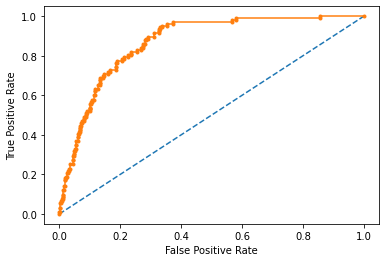

In [43]:
ns_probs = [0 for _ in range(len(y_test))]

probs = logreg_cv.predict_proba(X_ttest)
probs = probs[:,1]

mid_fpr, mid_tpr, thresholds = roc_curve(y_test, ns_probs)
fpr, tpr, thresholds = roc_curve(y_test, probs.reshape(-1,1))

plt.plot(mid_fpr, mid_tpr,  linestyle='--', label='mid-line')
plt.plot(fpr, tpr,  marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [44]:
print(f'The area under the AUC is {auc(fpr, tpr):.3f}.')

The area under the AUC is 0.870.


In [45]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.3409257806917797

Text(0.35, 0.42, 'Youdens Statistic')

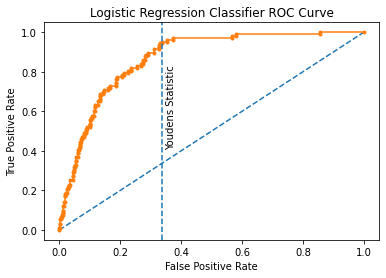

In [46]:
plt.plot(mid_fpr, mid_tpr,  linestyle='--', label='mid-line')
plt.plot(fpr, tpr,  marker='.')
plt.title('Logistic Regression Classifier ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axvline(x=fpr[np.where(thresholds==optimal_threshold)], linestyle='--')
plt.text(0.35,0.42,'Youdens Statistic',rotation=90)

In [47]:
y_pred =(logreg_cv.predict_proba(X_ttest)[:,1] >= optimal_threshold).astype(bool) # set optimal threshold

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.66      0.80      1073
           1       0.22      0.95      0.36       106

    accuracy                           0.69      1179
   macro avg       0.61      0.81      0.58      1179
weighted avg       0.92      0.69      0.76      1179



In [48]:
#Visualing log reg coefficients
#create column list
df1 = pd.get_dummies(X_train.INDHHIN2, prefix = "INDHHIN2")
df2 = pd.get_dummies(X_train.INDHHIN2, prefix = "INDFMIN2")
result = pd.concat([df1, df2], axis=1, join="inner")
col_list = num_list + list(result.columns)

In [49]:
X_ttrain_new = pd.DataFrame(X_ttrain, 
             columns=col_list)
X_ttrain_new

,RXDCOUNT,RIDAGEYR,BMXBMI,LBDHDDSI,LBXVIDMS,AVGSYBP,INDHHIN2_1.0,INDHHIN2_2.0,INDHHIN2_3.0,INDHHIN2_4.0,INDFMIN2_1.0,INDFMIN2_2.0,INDFMIN2_3.0,INDFMIN2_4.0
0,-0.656493,0.618147,-0.512331,-1.147657,-0.944521,1.826477,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.299625,-0.609071,-1.964626,-0.184673,-0.904605,-0.661492,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.414111,1.158123,-0.180378,-0.640823,0.361803,2.867953,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.057243,0.225437,-0.954935,0.094086,1.087538,-0.892931,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.656493,-0.020007,1.230422,-0.311381,-0.222414,-0.661492,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4652,-0.656493,-0.314539,-0.650645,-0.438090,0.336402,-0.082895,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4653,0.057243,1.354477,-0.871947,0.018061,-1.046124,2.000056,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4654,1.841582,1.550832,-0.858116,-1.147657,1.762472,0.379983,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4655,-0.656493,-1.099958,-0.622982,1.791979,-0.744943,-0.777212,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [50]:
lm = LogisticRegression(penalty = 'l2', C = 0.01, random_state=42,max_iter=500, class_weight='balanced')
lm.fit(X_ttrain_new, y_train)
odds = np.exp(lm.coef_[0])

pd.DataFrame(odds, 
             X_ttrain_new.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
RIDAGEYR,2.014130
RXDCOUNT,1.946588
BMXBMI,1.497168
AVGSYBP,1.315258
INDHHIN2_2.0,1.083872
INDFMIN2_3.0,1.070988
INDHHIN2_3.0,1.059610
INDFMIN2_2.0,1.029553
INDFMIN2_4.0,0.974970
INDHHIN2_1.0,0.950402
